## Edge handling experiments

For background on the derivation of the Richardson Lucy equation for non-circulant boundaries see [this Application note](http://bigwww.epfl.ch/deconvolution/challenge2013/index.html?p=doc_math_rl)

When image is extended we can think of it being equivalent to extending our 'solution space'.  Then the acquired image has been multiplied by a window w in the larger space.  And the RL equation becomes.

$$
    {o}_{k+1} = \frac{o_{k}\left[\frac{wi}{o_{k}*h}*h^*\right]}{n}
$$

Where ```n``` is a normalization factor calculated as ```HTones```.  The ```H``` operator on the image is convolution followed by multiplication by a window

$$
measuredimage=w(h*reality)
$$

So ```HTones``` would be window applied to the ```ones``` matrix followed by convolution by the conjugate of the PSF. 

$$
(w(ones))*h^*
$$



## Create an environment

In this environment we will install some tools we need for decon, this includes Jupyter noteook, clij2fft for non-circulant Richardson Lucy, devbio version of Napari for visualization, sdeconv for theoretical PSF, tnia-python for XYZ projected figures in the notebook. 
```
    conda create --name decon-env python=3.9
    conda activate decon-env
    pip install devbio-napari
    pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
    pip install napari-sdeconv
    pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-
```

## Load the test image

Load the test image and crop the image a bit as to speed up testing.  We also reverse the z axis of the stack so that it is consistent with positive 'depth' being below the coverslip.  We have cropped the test image to better demonstrate the performance of different edge handling approaches the cropped version of the image can be found [here](https://www.dropbox.com/scl/fo/mlxw2lp4vaaveuikkqqe8/h?dl=0&rlkey=wznzj1kb6g3yx5wo6lqyz5je8) and the original image can be found [here](http://bigwww.epfl.ch/deconvolution/bead/)

(50, 256, 256)


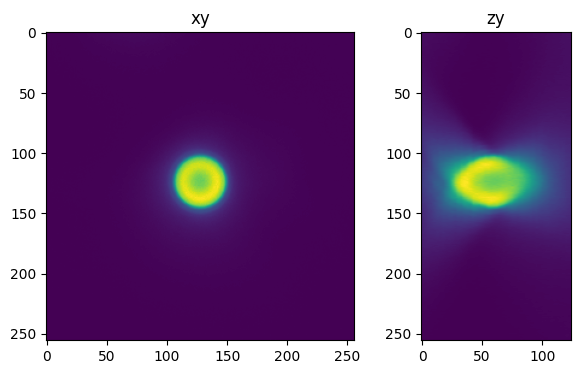

In [78]:
from skimage.io import imread
import numpy as np
from tnia.plotting.projections import show_xy_zy_slice

path_=r"D:\images\tnia-python-images\deconvolution\bead"

bead=imread(path_+"/bead-2.5um.tif")
z_to_view=bead.shape[0]//2

bead=bead[::-1,:,:]

xy_spacing = 0.0645
z_spacing=.16

ratio = z_spacing/xy_spacing

print(bead.shape)

fig=show_xy_zy_slice(bead,128,128,z_to_view, sz=ratio, figsize=(7,4))


## Create the PSF

Here we generate the PSF.  The meta data does not include the refractive index of the medium the bead is embedded in.  It is likely close to, but not exactly the refractive index of the lens immersion media, in a previous experiment we dtermined the RI of the embedding media to be apr. 1.49.  

sdeconv 1.x.x detected


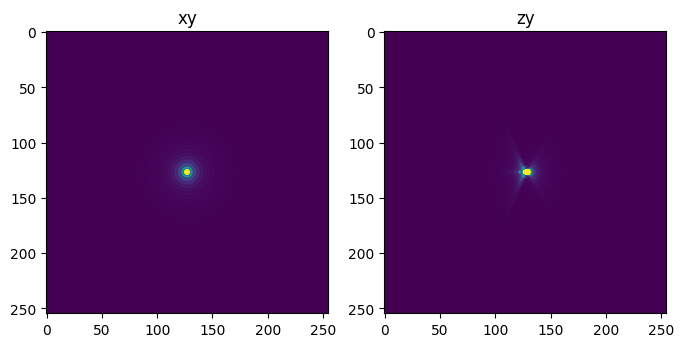

In [51]:
from tnia.nd.ndutil import centercrop
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.plotting.projections import show_xy_zy_max
from tnia.deconvolution.psfs import recenter_psf_axial
from skimage.io import imsave

ni=1.518
ns  = 1.49
NA=1.4
w=0.530

xy_spacing = 0.0645
z_spacing=.16

xy_psf_dim=255
z_compute_psf_dim=599
z_crop_psf_dim=101

#depth to compute PSF at
d=128*z_spacing

psf  = gibson_lanni_3D(NA, ni, ns, xy_spacing, z_spacing, xy_psf_dim, z_compute_psf_dim, d, w)
psf = psf.astype('float32')

psf=recenter_psf_axial(psf, 255)
fig=show_xy_zy_max(psf, vmax=psf.max()/4, figsize=(8,4))

## Set deconvolution parameters

For the first experiment we deconvolve a centered bead for 2000 iterations.  Even though the bead is centered we still see artifacts when proper edge handling is not used. 

In [66]:
from clij2fft.richardson_lucy import richardson_lucy_nc, richardson_lucy
import RedLionfishDeconv as rl

bead = bead.astype('float32')
regularization_factor=0
iterations=2000
psf_crop=centercrop(psf, (bead.shape[0], psf.shape[1], psf.shape[2]))

# renormalize psf
psf_crop = psf_crop/psf_crop.sum()

## Perform deconvolution with RedLionFish, CLIJ Non-circulant, and CLiJ Circulant

In [67]:

import RedLionfishDeconv as rl
decon_rl=rl.doRLDeconvolutionFromNpArrays(bead, psf_crop, niter=iterations, method='gpu', resAsUint8=False )

In [68]:
regularization_factor=0
im_decon_clij_nc = richardson_lucy_nc(bead, psf_crop, iterations , regularization_factor)
im_decon_clij= richardson_lucy(bead, psf_crop, iterations , regularization_factor)


get lib
get lib


Text(0.5, 0.98, 'decon clij non-circulant')

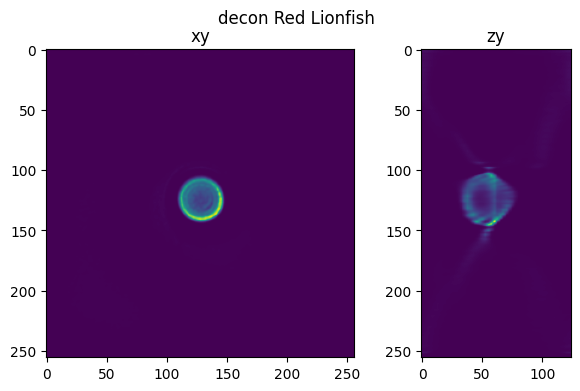

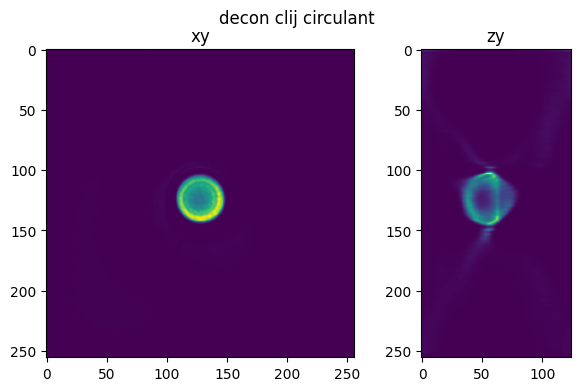

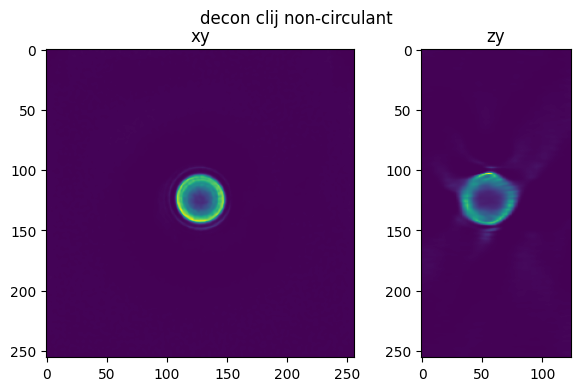

In [69]:

fig=show_xy_zy_slice(decon_rl,128,128,z_to_view, sz=ratio, figsize=(7,4))
fig.suptitle('decon Red Lionfish')
fig=show_xy_zy_slice(im_decon_clij,128,128,z_to_view, sz=ratio, figsize=(7,4))
fig.suptitle('decon clij circulant')
fig=show_xy_zy_slice(im_decon_clij_nc,128,128,z_to_view, sz=ratio, figsize=(7,4))
fig.suptitle('decon clij non-circulant')

## Perform the same tests using a half bead

Text(0.5, 0.98, 'half bead')

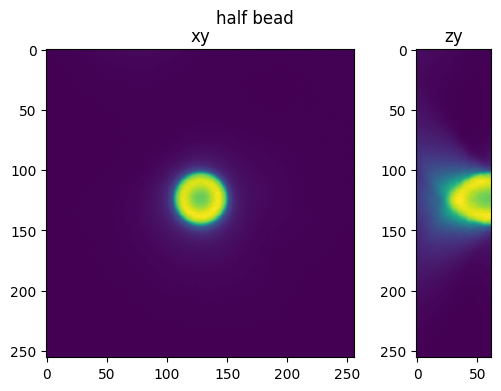

In [76]:
half_bead=bead[:bead.shape[0]//2,:,:]
z_to_view=half_bead.shape[0]-1
fig=show_xy_zy_slice(half_bead,128,128,z_to_view, sz=ratio, figsize=(6,4))
fig.suptitle('half bead')

In [71]:

psf_crop=centercrop(psf, (half_bead.shape[0], psf.shape[1], psf.shape[2]))

In [72]:

decon_rl=rl.doRLDeconvolutionFromNpArrays(half_bead, psf_crop, niter=iterations, method='gpu', resAsUint8=False )

In [73]:

im_decon_clij_nc = richardson_lucy_nc(half_bead, psf_crop, iterations , regularization_factor)
im_decon_clij = richardson_lucy(half_bead, psf_crop, iterations , regularization_factor)

get lib
get lib


Text(0.5, 0.98, 'decon clij circulant')

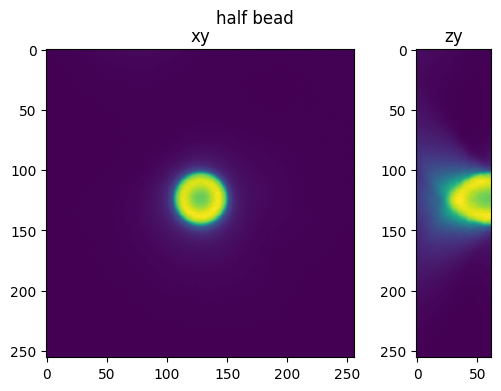

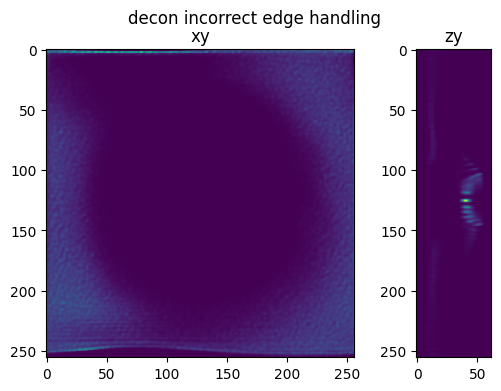

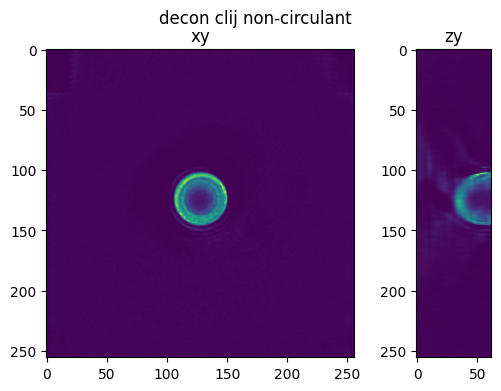

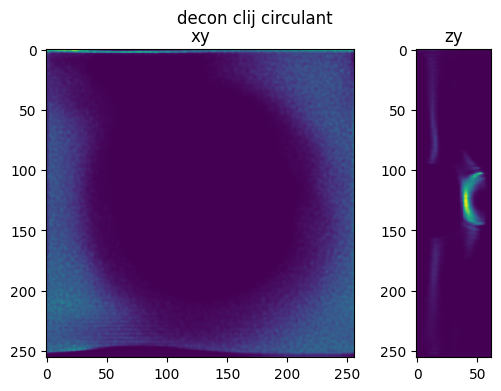

In [77]:
fig=show_xy_zy_slice(half_bead,128,128,z_to_view, sz=ratio, figsize=(6,4))
fig.suptitle('half bead')
fig=show_xy_zy_slice(decon_rl,128,128,z_to_view, sz=ratio, figsize=(6,4))
fig.suptitle('decon incorrect edge handling')
fig=show_xy_zy_slice(im_decon_clij_nc,128,128,z_to_view, sz=ratio, figsize=(6,4))
fig.suptitle('decon clij non-circulant')
fig=show_xy_zy_slice(im_decon_clij,128,128,z_to_view, sz=ratio, figsize=(6,4))
fig.suptitle('decon clij circulant')